## Data Prepartion

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
# Load the dataset
data = pd.read_csv('/content/2023_smartFarm_AI_hackathon_dataset.csv')

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')

# Drop columns with 100% zeros
zero_percentage = (data == 0).sum() / len(data) * 100
data_cleaned = data.drop(columns=zero_percentage[zero_percentage == 100].index)

# Define the target variables
y_heating = data_cleaned['HeatingEnergyUsage_cumsum']
y_outtrn = data_cleaned['outtrn_cumsum']

# Extracting temporal features
data_cleaned['day_of_week'] = data_cleaned['date'].dt.dayofweek
data_cleaned['month'] = data_cleaned['date'].dt.month
seasons = {12: 'Winter', 1: 'Winter', 2: 'Winter',
           3: 'Spring', 4: 'Spring', 5: 'Spring',
           6: 'Summer', 7: 'Summer', 8: 'Summer',
           9: 'Fall', 10: 'Fall', 11: 'Fall'}
data_cleaned['season'] = data_cleaned['month'].map(seasons)

# Define predictors
X = data_cleaned.drop(columns=['HeatingEnergyUsage_cumsum', 'outtrn_cumsum', 'date'])

# Feature Engineering - Interaction Terms (As an example)
X['interaction_term_1'] = X['inTp'] * X['inHd']

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=['frmDist', 'day_of_week', 'month', 'season'])

# Splitting the data
X_train_encoded, X_val_encoded, y_heating_train, y_heating_val = train_test_split(X_encoded, y_heating, test_size=0.2, random_state=42)

# Features to transform
features_to_transform = ['WaterUsage', 'FertilizerUsage', 'CO2Usage']
for feature in features_to_transform:
    X_train_encoded[feature] = np.log1p(X_train_encoded[feature])

# Handling Outliers using IQR for all numeric features
for column in X_train_encoded.select_dtypes(include=[np.number]).columns:
    Q1 = X_train_encoded[column].quantile(0.25)
    Q3 = X_train_encoded[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    X_train_encoded[column] = np.where(X_train_encoded[column] < lower_bound, lower_bound, X_train_encoded[column])
    X_train_encoded[column] = np.where(X_train_encoded[column] > upper_bound, upper_bound, X_train_encoded[column])

# Create lag and rolling window features
data_cleaned_sorted = data_cleaned.sort_values(by='date')
features_to_lag_rolling = ['inTp', 'inHd']

for feature in features_to_lag_rolling:
    for lag in range(1, 4):  # for 3 days
        col_name = f"{feature}_lag_{lag}"
        data_cleaned_sorted[col_name] = data_cleaned_sorted.groupby('frmDist')[feature].shift(lag)

        roll_name = f"{feature}_rolling_avg_{lag}"
        data_cleaned_sorted[roll_name] = data_cleaned_sorted.groupby('frmDist')[feature].rolling(window=lag).mean().reset_index(0, drop=True)

X_expanded = data_cleaned_sorted.drop(columns=['HeatingEnergyUsage_cumsum', 'outtrn_cumsum', 'date'])
X_expanded_encoded = pd.get_dummies(X_expanded, columns=['frmDist', 'day_of_week', 'month', 'season'])
X_train_expanded, X_val_expanded, y_heating_train_exp, y_heating_val_exp = train_test_split(X_expanded_encoded, y_heating, test_size=0.2, random_state=42)

# Fill NaN values using forward fill and backward fill
X_train_expanded.fillna(method='ffill', inplace=True)  # Forward fill
X_train_expanded.fillna(method='bfill', inplace=True)  # Backward fill (if there are any NaNs left)

# Forward fill and backward fill for validation set
X_val_expanded.fillna(method='ffill', inplace=True)
X_val_expanded.fillna(method='bfill', inplace=True)

# Normalize the data
scaler = StandardScaler()
X_train_expanded = scaler.fit_transform(X_train_expanded)
X_val_expanded = scaler.transform(X_val_expanded)



## Baseline

### Linear Regression

In [2]:


linear_reg = LinearRegression()
linear_reg.fit(X_train_expanded, y_heating_train_exp)
lr_predictions = linear_reg.predict(X_val_expanded)

lr_rmse = np.sqrt(mean_squared_error(y_heating_val_exp, lr_predictions))
lr_r2 = r2_score(y_heating_val_exp, lr_predictions)
print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression R^2:", lr_r2)


Linear Regression RMSE: 555447.8841501994
Linear Regression R^2: 0.007006582440675091


In [3]:

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train_expanded, y_heating_train_exp)
rf_predictions = random_forest.predict(X_val_expanded)

rf_rmse = np.sqrt(mean_squared_error(y_heating_val_exp, rf_predictions))
rf_r2 = r2_score(y_heating_val_exp, rf_predictions)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest R^2:", rf_r2)


Random Forest RMSE: 492888.72630776314
Random Forest R^2: 0.2180886709086418


## Deep Learning

Epoch 1/100
2121/2121 [==============================] - 7s 3ms/step - loss: 291813588992.0000 - val_loss: 309868068864.0000
Epoch 2/100
2121/2121 [==============================] - 7s 3ms/step - loss: 285357113344.0000 - val_loss: 308095057920.0000
Epoch 3/100
2121/2121 [==============================] - 5s 2ms/step - loss: 283617230848.0000 - val_loss: 307366690816.0000
Epoch 4/100
2121/2121 [==============================] - 7s 3ms/step - loss: 282755301376.0000 - val_loss: 307010961408.0000
Epoch 5/100
2121/2121 [==============================] - 6s 3ms/step - loss: 282028081152.0000 - val_loss: 306893357056.0000
Epoch 6/100
2121/2121 [==============================] - 7s 3ms/step - loss: 281449824256.0000 - val_loss: 306292490240.0000
Epoch 7/100
2121/2121 [==============================] - 6s 3ms/step - loss: 280720310272.0000 - val_loss: 305858838528.0000
Epoch 8/100
2121/2121 [==============================] - 6s 3ms/step - loss: 280022024192.0000 - val_loss: 305552588800.0000


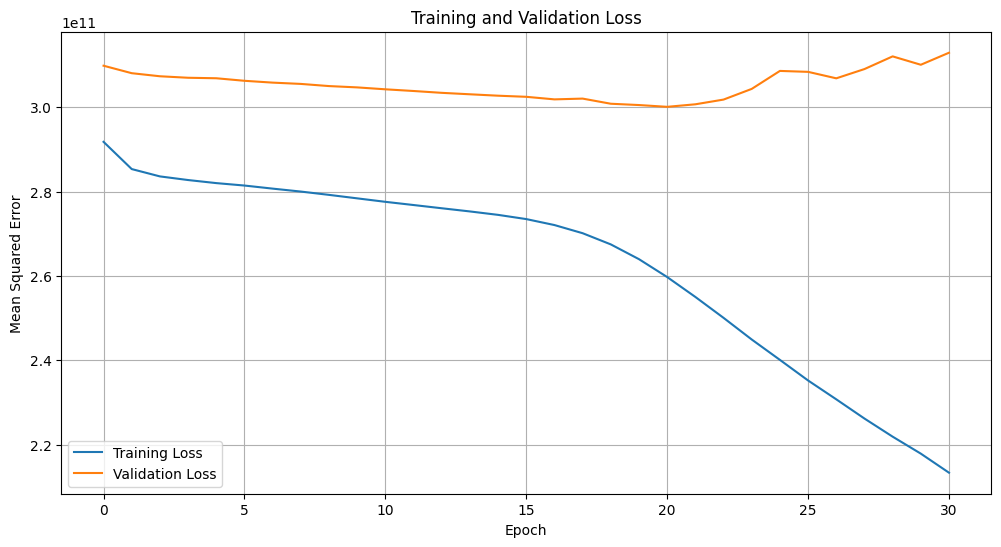

In [5]:

# Define the neural network model
def build_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # No activation for the output layer for regression
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the model
input_shape = [X_train_expanded.shape[1]]
model = build_model(input_shape)

# Define early stopping and model checkpointing
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_expanded, y_heating_train_exp,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_expanded, y_heating_val_exp),
    callbacks=[early_stopping],
    verbose=1
)

# After training, evaluate the model on the validation set
val_predictions = model.predict(X_val_expanded)
nn_rmse = np.sqrt(mean_squared_error(y_heating_val_exp, val_predictions))
nn_r2 = r2_score(y_heating_val_exp, val_predictions)

print("Neural Network RMSE:", nn_rmse)
print("Neural Network R^2:", nn_r2)

# Plotting training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


### LSTM

In [14]:
# Reshape data for LSTM
X_train_reshaped = X_train_expanded.reshape(X_train_expanded.shape[0], 1, X_train_expanded.shape[1])
X_val_reshaped = X_val_expanded.reshape(X_val_expanded.shape[0], 1, X_val_expanded.shape[1])

# Ensure there are no NaN values in the training data
assert not np.isnan(X_train_reshaped).any()
assert not np.isnan(y_heating_train_exp).any()

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])


# Function to build the three LSTM models
def build_lstm_model_v1(input_shape):
    model = keras.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=input_shape, kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.LSTM(64, kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def build_lstm_model_v2(input_shape):
    model = keras.Sequential([
        layers.LSTM(256, return_sequences=True, input_shape=input_shape, kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        layers.LSTM(128, kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def build_lstm_model_v3(input_shape):
    model = keras.Sequential([
        layers.LSTM(64, input_shape=input_shape, kernel_initializer='he_normal'),
        layers.Dropout(0.1),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Training loop for different batch sizes
batch_sizes = [32, 64, 128]
models = [build_lstm_model_v1, build_lstm_model_v2, build_lstm_model_v3]
results = {}

for model_func in models:
    for batch_size in batch_sizes:
        model_name = f"{model_func.__name__}_batch_{batch_size}"
        print(f"Training model: {model_name}")

        model = model_func(input_shape)
        history = model.fit(
            X_train_reshaped, y_heating_train_exp,
            epochs=5,  # Reduced epochs for quick observation
            batch_size=batch_size,
            validation_data=(X_val_reshaped, y_heating_val_exp),
            callbacks=[early_stopping],
            verbose=1
        )

        val_predictions = model.predict(X_val_reshaped)
        rmse = np.sqrt(mean_squared_error(y_heating_val_exp, val_predictions))
        r2 = r2_score(y_heating_val_exp, val_predictions)
        results[model_name] = [rmse, r2]


Training model: build_lstm_model_v1_batch_32
Epoch 1/5
2121/2121 [==============================] - 44s 9ms/step - loss: 299968200704.0000 - val_loss: 312936267776.0000
Epoch 2/5
2121/2121 [==============================] - 19s 9ms/step - loss: 288058343424.0000 - val_loss: 311087759360.0000
Epoch 3/5
2121/2121 [==============================] - 18s 9ms/step - loss: 286810603520.0000 - val_loss: 310787309568.0000
Epoch 4/5
2121/2121 [==============================] - 20s 10ms/step - loss: 285699014656.0000 - val_loss: 310704013312.0000
Epoch 5/5
531/531 [==============================] - 3s 3ms/step
Training model: build_lstm_model_v1_batch_64
Epoch 1/5
1061/1061 [==============================] - 18s 13ms/step - loss: 304867639296.0000 - val_loss: 322839805952.0000
Epoch 2/5
1061/1061 [==============================] - 12s 12ms/step - loss: 292533370880.0000 - val_loss: 311636590592.0000
Epoch 3/5
1061/1061 [==============================] - 13s 12ms/step - loss: 287448268800.0000 - v

In [16]:
# Printing out the results
for model_name, val in results.items():
    rmse, r2 = val
    print(f"Model: {model_name} - RMSE: {rmse}, R2: {r2}")

Model: build_lstm_model_v1_batch_32 - RMSE: 556527.8477132707, R2: 0.003141452060485994
Model: build_lstm_model_v1_batch_64 - RMSE: 557105.0788633166, R2: 0.001072494611757735
Model: build_lstm_model_v1_batch_128 - RMSE: 557288.224323345, R2: 0.00041560198509094093
Model: build_lstm_model_v2_batch_32 - RMSE: 552173.7117693581, R2: 0.01867878166573056
Model: build_lstm_model_v2_batch_64 - RMSE: 554696.0586766886, R2: 0.00969289205386581
Model: build_lstm_model_v2_batch_128 - RMSE: 555153.8878272792, R2: 0.008057479064434214
Model: build_lstm_model_v3_batch_32 - RMSE: 570713.8244168137, R2: -0.048326396437814
Model: build_lstm_model_v3_batch_64 - RMSE: 572762.0922073175, R2: -0.055864697772724625
Model: build_lstm_model_v3_batch_128 - RMSE: 574614.5653504075, R2: -0.06270566747047113


Additional Preprocessing

In [49]:


# Load the dataset
data = pd.read_csv('/content/2023_smartFarm_AI_hackathon_dataset.csv')

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')

# Extracting temporal features: hour, day of week, month
data['hour'] = data['date'].dt.hour
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month

# Convert cyclic temporal features to sine and cosine transformations
hours_in_day = 24
days_in_week = 7
months_in_year = 12

data['sin_hour'] = np.sin(2*np.pi*data['hour']/hours_in_day)
data['cos_hour'] = np.cos(2*np.pi*data['hour']/hours_in_day)

data['sin_day_of_week'] = np.sin(2*np.pi*data['day_of_week']/days_in_week)
data['cos_day_of_week'] = np.cos(2*np.pi*data['day_of_week']/days_in_week)

data['sin_month'] = np.sin(2*np.pi*data['month']/months_in_year)
data['cos_month'] = np.cos(2*np.pi*data['month']/months_in_year)

# Interaction terms
data['inTp_x_inHd'] = data['inTp'] * data['inHd']

# Create lag and rolling window features
data_sorted = data.sort_values(by='date')
features_to_lag_rolling = ['inTp', 'inHd']

for feature in features_to_lag_rolling:
    for lag in range(1, 4):  # for 3 days
        col_name = f"{feature}_lag_{lag}"
        data_sorted[col_name] = data_sorted.groupby('frmDist')[feature].shift(lag)

        roll_name = f"{feature}_rolling_avg_{lag}"
        data_sorted[roll_name] = data_sorted.groupby('frmDist')[feature].rolling(window=lag).mean().reset_index(0, drop=True)


# One-hot encoding
data = pd.get_dummies(data, columns=['frmDist', 'day_of_week', 'month'])


# Fill NaN values using forward fill and backward fill
data_sorted.fillna(method='ffill', inplace=True)  # Forward fill
data_sorted.fillna(method='bfill', inplace=True)  # Backward fill (if there are any NaNs left)



# Separate predictors and targets
X = data_sorted.drop(columns=['HeatingEnergyUsage_cumsum', 'outtrn_cumsum', 'date'])
y = data_sorted[['HeatingEnergyUsage_cumsum', 'outtrn_cumsum']]

# Train-test split
X_train_expanded, X_val_expanded, y_heating_train_exp, y_heating_val_exp, y_outtrn_train_exp, y_outtrn_val_exp = train_test_split(X_expanded_encoded, y_heating, y_outtrn, test_size=0.2, random_state=42)

# Normalize the predictors
scaler_X = MinMaxScaler()
X_train_expanded_scaled = scaler_X.fit_transform(X_train_expanded)
X_val_expanded_scaled = scaler_X.transform(X_val_expanded)

# Normalize the targets
scaler_y_heating = MinMaxScaler()
y_heating_train_exp_scaled = scaler_y_heating.fit_transform(y_heating_train_exp.values.reshape(-1, 1))
y_heating_val_exp_scaled = scaler_y_heating.transform(y_heating_val_exp.values.reshape(-1, 1))

scaler_y_outtrn = MinMaxScaler()
y_outtrn_train_exp_scaled = scaler_y_outtrn.fit_transform(y_outtrn_train_exp.values.reshape(-1, 1))
y_outtrn_val_exp_scaled = scaler_y_outtrn.transform(y_outtrn_val_exp.values.reshape(-1, 1))



In [52]:




def build_multi_output_model(input_shape):
    # Shared Input
    shared_input = layers.Input(shape=input_shape, name='shared_input')

    # Shared Layers
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(shared_input)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.2)(x)

    # HeatingEnergyUsage_cumsum Branch
    heating_output = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    heating_output = layers.Dropout(0.2)(heating_output)
    heating_output = layers.Dense(1, name='heating_output')(heating_output)

    # outtrn_cumsum Branch
    outtrn_output = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    outtrn_output = layers.Dropout(0.2)(outtrn_output)
    outtrn_output = layers.Dense(1, name='outtrn_output')(outtrn_output)

    # Combine into a Model
    model = keras.Model(inputs=shared_input, outputs=[heating_output, outtrn_output])

    # Compile the Model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# Create the multi-output model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
multi_output_model = build_multi_output_model(input_shape)

# Print the model summary
multi_output_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 shared_input (InputLayer)   [(None, 1, 430)]             0         []                            
                                                                                                  
 dense_58 (Dense)            (None, 1, 128)               55168     ['shared_input[0][0]']        
                                                                                                  
 dropout_39 (Dropout)        (None, 1, 128)               0         ['dense_58[0][0]']            
                                                                                                  
 dense_59 (Dense)            (None, 1, 64)                8256      ['dropout_39[0][0]']          
                                                                                            

In [53]:


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = multi_output_model.fit(
    X_train_reshaped,
    {'heating_output': y_heating_train_exp_scaled, 'outtrn_output': y_outtrn_train_exp_scaled},
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, {'heating_output': y_heating_val_exp_scaled, 'outtrn_output': y_outtrn_val_exp_scaled}),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
2112/2121 [============================>.] - ETA: 0s - loss: 0.1451 - heating_output_loss: 0.0680 - outtrn_output_loss: 0.0771 - heating_output_root_mean_squared_error: 0.2607 - outtrn_output_root_mean_squared_error: 0.2776

ValueError: ignored

In [41]:
X_train_reshaped.shape

(67872, 1, 430)

In [48]:


X_val_reshaped = X_val_expanded.to_numpy().astype('float32').reshape(X_val_expanded.shape[0], 1, X_val_expanded.shape[1])
predictions = multi_output_model.predict(X_val_reshaped)


# RMSE for heating
rmse_heating = np.sqrt(mean_squared_error(y_heating_val_exp_scaled, predictions_heating))
print(f"RMSE for Heating: {rmse_heating}")

# R2 for heating
r2_heating = r2_score(y_heating_val_exp_scaled, predictions_heating)
print(f"R2 for Heating: {r2_heating}")

# RMSE for outtrn
rmse_outtrn = np.sqrt(mean_squared_error(y_outtrn_val_exp_scaled, predictions_outtrn))
print(f"RMSE for Outtrn: {rmse_outtrn}")

# R2 for outtrn
r2_outtrn = r2_score(y_outtrn_val_exp_scaled, predictions_outtrn)
print(f"R2 for Outtrn: {r2_outtrn}")


ValueError: ignored

In [44]:
# 1. Print the shape of X_train_expanded and X_val_expanded
print("X_train_expanded shape:", X_train_expanded.shape)
print("X_val_expanded shape:", X_val_expanded.shape)

# 2. Compare the columns of X_train_expanded and X_val_expanded
missing_columns_in_val = set(X_train_expanded.columns) - set(X_val_expanded.columns)
missing_columns_in_train = set(X_val_expanded.columns) - set(X_train_expanded.columns)

print("Columns present in train but missing in validation:", missing_columns_in_val)
print("Columns present in validation but missing in train:", missing_columns_in_train)


X_train_expanded shape: (67872, 434)
X_val_expanded shape: (16968, 434)
Columns present in train but missing in validation: set()
Columns present in validation but missing in train: set()


In [45]:
print(X_train_expanded.columns)


Index(['inTp', 'inHd', 'otmsuplyqy', 'acSlrdQy', 'cunt', 'ph', 'outTp',
       'outWs', 'inCo2', 'ec',
       ...
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object', length=434)
